# Exercice 3

In [3]:
using JuMP, Gurobi, DataFrames, CSV, Random, LinearAlgebra, PyPlot, Dates, Statistics

# Question a

* Model for the l0-regularization 

In [8]:
function regularized_regression_l0(y, X, ρ)
    M = 200
    n,m = size(X)
    model = Model(solver = GurobiSolver(TimeLimit = 60))
    
    @variable(model, β[1:m])
    @variable(model, z[1:m], Bin)
    
    @objective(model, Min, sum((y - X*β).^2) + ρ*sum(z))
    
    for i in 1:m
        @constraint(model, β[i] <= M * z[i])
        @constraint(model, (-β[i]) <= M * z[i])
    end
    
    sol = solve(model)
    return (getobjectivevalue(model), getvalue(β))
    
end

regularized_regression_l0 (generic function with 1 method)

* Model for the l1-regularization 

In [9]:
function regularized_regression_l1(y, X, ρ)
    n,m = size(X)
    model = Model(solver = GurobiSolver(TimeLimit=45))
    
    @variable(model, β[1:m])
    @variable(model, z[1:m])
    
    @objective(model, Min, sum((y - X*β).^2) + ρ*sum(z))
    
    for i in 1:m
        @constraint(model, (z[i]) >= β[i])
        @constraint(model, (z[i]) >= - β[i])
    end
    
    sol = solve(model)
    
    return (getobjectivevalue(model), getvalue(β))
    
end

regularized_regression_l1 (generic function with 1 method)

* Model for the l2-regularization 

In [10]:
function regularized_regression_l2(y, X, ρ)
   
    n,m = size(X)
    model = Model(solver = GurobiSolver(TimeLimit=45))
    
    @variable(model, β[1:m])
    
    @objective(model, Min, sum((y - X*β).^2) + ρ*sum(β.^2))
    
    sol = solve(model)
    
    return (getobjectivevalue(model), getvalue(β))
    
end

regularized_regression_l2 (generic function with 1 method)

## Question b

In [11]:
sparseX2 = CSV.read("sparseX2.csv", header = false)
sparseY2 = CSV.read("sparseY2.csv", header = false)

,Column1
,Float64
1,2.34286
2,-3.04512
3,-5.90616
4,0.467956
5,-4.52402
6,1.77557
7,-1.1383
8,-3.26992
9,5.39506


Creation of the validation, training and testing sets.

In [12]:
function split_data(X, y, val, test)
    n = size(X, 1)
    index = shuffle([i for i in 1:n])
    
    size_validation = floor(Int,val*n)    
    size_test = floor(Int,(val+test)*n)
    
    ind_validation = index[1:size_validation]
    ind_test = index[size_validation+1:size_test]
    ind_train = index[size_test+1:n]
    
    X_validation = X[ind_validation, :]
    X_test = X[ind_test, :]
    X_train = X[ind_train, :]

    y_validation = y[ind_validation, :]
    y_test = y[ind_test, :]
    y_train = y[ind_train, :]
    
    return (
        convert(Matrix,X_validation), 
        convert(Matrix,X_test), 
        convert(Matrix,X_train), 
        convert(Matrix, y_validation), 
        convert(Matrix,y_test),
        convert(Matrix,y_train)
        )
    
end

split_data (generic function with 1 method)

In [13]:
(
    X_validation, 
    X_test, 
    X_train, 
    y_validation, 
    y_test,
    y_train
) = split_data(sparseX2, sparseY2, 0.25, 0.25)

([-0.030266886646762546 -0.1569479584427068 … -1.5929387112087472 1.0586594211530422; 1.2224618484680618 -0.8548933573000406 … 1.446064847696561 0.788663161665886; … ; -1.3851080676759138 -0.29961787965293785 … 0.3717303873230274 1.6368541078980345; -1.360732996599522 -1.3931348022399552 … -0.9832304861662079 1.3235023732095377], [-0.09220577556331351 -0.5595352207192429 … -0.2974595786366185 0.8166449517726251; -1.546731741900333 1.107610369079468 … -0.2937388398210462 0.49936029237575696; … ; 1.1294094358843267 -2.620564252102542 … -0.4638334230593729 0.330754711922663; 1.7351656660543822 -1.5544394018554584 … -0.7438578336296205 1.3070709890436114], [1.880622174631185 0.8665458026221579 … 0.35365275274181157 0.1911183094589185; -0.16528310111426064 -1.1990648633034413 … 0.9880843467027854 0.3381981362887111; … ; -0.34662848289604303 -0.35082962248724037 … -0.729606820473219 -1.295307615247745; -1.7738332534080556 0.6677002797481758 … 1.296905044345215 -1.095862161479504], [-2.263276

We choose ρ as the value that gives the best mean squared prediction error on the validation set.

In [14]:
function mean_square_error(y_actual, y_predicted)
    return sum((y_actual - y_predicted).^2)
end

mean_square_error (generic function with 1 method)

In [15]:
function compute_error_l0(ρ, X, y)
    objective, β = regularized_regression_l0(y_train, X_train, ρ)
    error = mean_square_error(y, X * β)
    return error
end

compute_error_l0 (generic function with 1 method)

In [16]:
function compute_error_l1(ρ, X, y)
    objective, β = regularized_regression_l1(y_train, X_train, ρ)
    error = mean_square_error(y, X * β)
    return error
end

compute_error_l1 (generic function with 1 method)

In [17]:
function compute_error_l2(ρ, X, y)
    objective, β = regularized_regression_l2(y_train, X_train, ρ)
    error = mean_square_error(y, X * β)
    return error
end

compute_error_l2 (generic function with 1 method)

In [18]:
ρ_l0 = vcat([i/2 for i=1:80])
errors_l0 = zeros(length(ρ_l0))

for i in 1:length(errors_l0)
    print("__________________________", "iteration : ", i, "__________________________")
    errors_l0[i] = compute_error_l0(ρ_l0[i], X_validation, y_validation)
end

__________________________iteration : 1__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.472670e+02, 1071 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -947.26702    0   98    0.00000 -947.26702      -     -    0s
H    0     0 

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


iteration : 2__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.471986e+02, 1042 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -947.19856    0   97    0.00000 -947.19856      -     -    0s
H    0     0                    -871.55

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.471355e+02, 1031 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -947.13545    0   97    0.00000 -947.13545      -     -    0s
H    0     0                    -845.1209353 -947.13545  12.1%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 5__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.470135e+02, 1018 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -947.01345    0   97    0.00000 -947.01345      -     -    0s
H    0     0                    -813.0242076 -947.01345  16.5%     -    0s
   

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


iteration : 7__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.468951e+02, 1021 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -946.89514    0   96    0.00000 -946.89514      -     -    0s
H    0     0                    -784.90

__________________________iteration : 11__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.466624e+02, 1014 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -946.66241    0   95    0.00000 -946.66241      -     -    0s
H    0     0

__________________________iteration : 16__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.463784e+02, 1013 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -946.37842    0   93    0.00000 -946.37842      -     -    0s
H    0     0

__________________________iteration : 21__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.461008e+02, 1006 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -946.10081    0   92    0.00000 -946.10081      -     -    0s
H    0     0

__________________________iteration : 25__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.458825e+02, 1020 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -945.88250    0   92    0.00000 -945.88250      -     -    0s
H    0     0

__________________________iteration : 29__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.456670e+02, 1030 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -945.66700    0   94    0.00000 -945.66700      -     -    0s
H    0     0

__________________________iteration : 33__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.454550e+02, 1021 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -945.45500    0   94    0.00000 -945.45500      -     -    0s
H    0     0

__________________________iteration : 37__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.452467e+02, 1017 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -945.24672    0   93    0.00000 -945.24672      -     -    0s
H    0     0

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.450927e+02, 1016 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -945.09272    0   92    0.00000 -945.09272      -     -    0s
H    0     0                    -348.9926903 -945.09272   171%     -    0s
H  

__________________________iteration : 44__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.448899e+02, 1017 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.88990    0   94    0.00000 -944.88990      -     -    0s
H    0     0

__________________________iteration : 48__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.446900e+02, 1023 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.69001    0   94    0.00000 -944.69001      -     -    0s
H    0     0

__________________________iteration : 52__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.444931e+02, 1019 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.49306    0   95    0.00000 -944.49306      -     -    0s
H    0     0

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 56__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.442991e+02, 1017 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.29906    0   95    0.00000 -944.29906      -     -    0s
H    0     0                    -366.7656613 -944.29906   157%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 58__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.442032e+02, 1023 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.20316    0   95    0.00000 -944.20316      -     -    0s
H    0     0                    -376.1439046 -944.20316   151%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 60__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.441080e+02, 1025 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.10800    0   95    0.00000 -944.10800      -     -    0s
H    0     0                    -246.9876152 -944.10800   282%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 62__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.440136e+02, 1023 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -944.01357    0   95    0.00000 -944.01357      -     -    0s
H    0     0                    -388.3475571 -944.01357   143%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 64__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.439199e+02, 1021 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.91989    0   95    0.00000 -943.91989      -     -    0s
H    0     0                    -376.5135224 -943.91989   151%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 66__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.438269e+02, 1023 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.82693    0   95    0.00000 -943.82693      -     -    0s
H    0     0                    -376.0215007 -943.82693   151%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 68__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.437347e+02, 1026 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.73472    0   93    0.00000 -943.73472      -     -    0s
H    0     0                    -371.0916263 -943.73472   154%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 70__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.436432e+02, 1028 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.64317    0   91    0.00000 -943.64317      -     -    0s
H    0     0                    -356.3512612 -943.64317   165%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 72__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.435522e+02, 1028 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.55216    0   91    0.00000 -943.55216      -     -    0s
H    0     0                    -359.5511093 -943.55216   162%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 74__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.434617e+02, 1024 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.46168    0   92    0.00000 -943.46168      -     -    0s
H    0     0                    -270.9492669 -943.46168   248%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 76__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.433718e+02, 1008 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.37181    0   90    0.00000 -943.37181      -     -    0s
H    0     0                    -265.9492669 -943.37181   255%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 78__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.432825e+02, 1015 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.28248    0   90    0.00000 -943.28248      -     -    0s
H    0     0                    -260.9492669 -943.28248   261%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


__________________________iteration : 80__________________________

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.431936e+02, 1022 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -943.19360    0   90    0.00000 -943.19360      -     -    0s
H    0     0                    -285.0434050 -943.19360   231%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


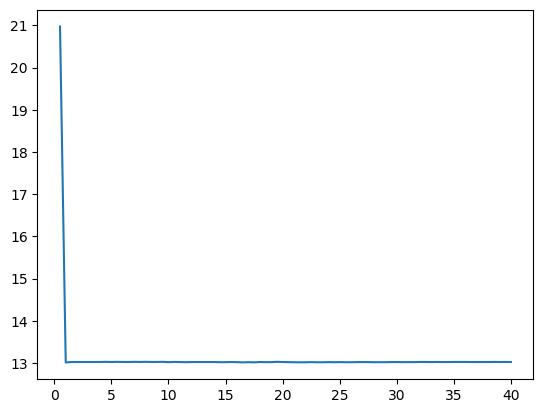

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141dc16d8>

In [19]:
plot(ρ_l0, errors_l0)

In [20]:
ρ_optimal_l0 = ρ_l0[argmin(errors_l0)]

1.0

In [21]:
ρ_l1 = [i/10 for i=1:400]
errors_l1 = zeros(length(ρ_l1))

for i in 1:length(errors_l1)
    print("__________________________", "iteration : ", i, "__________________________")
    errors_l1[i] = compute_error_l1(ρ_l1[i], X_validation, y_validation)
end

__________________________iteration : 1__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.99000000e+04  0.00000000e+00  0.00e+00 2.60e+02  1.00e+06     0s
   1   1.89666289e+04 -9.45388850e+02  3.28e-07 2

__________________________iteration : 6__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.19400000e+05  0.00000000e+00  0.00e+00 2.60e+02  1.00e+06     0s
   1   1.18357770e+05 -9.45858089e+02  1.56e-07 1

__________________________iteration : 11__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.18900000e+05  0.00000000e+00  0.00e+00 2.59e+02  1.00e+06     0s
   1   2.17473590e+05 -9.45991510e+02  2.65e-07 

__________________________iteration : 16__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.18400000e+05  0.00000000e+00  0.00e+00 2.59e+02  1.00e+06     0s
   1   3.16438543e+05 -9.46458366e+02  5.38e-07 

__________________________iteration : 21__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.17900000e+05  0.00000000e+00  0.00e+00 2.58e+02  1.00e+06     0s
   1   4.15205624e+05 -9.46799014e+02  1.66e-07 

__________________________iteration : 26__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.17400000e+05  0.00000000e+00  0.00e+00 2.58e+02  1.00e+06     0s
   1   5.13775961e+05 -9.46793634e+02  3.37e-07 

__________________________iteration : 31__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.16900000e+05  0.00000000e+00  0.00e+00 2.57e+02  1.00e+06     0s
   1   6.12149337e+05 -9.46788475e+02  2.50e-07 

__________________________iteration : 36__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.16400000e+05  0.00000000e+00  0.00e+00 2.57e+02  1.00e+06     0s
   1   7.10326046e+05 -9.46783544e+02  2.66e-07 

__________________________iteration : 41__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.15900000e+05  0.00000000e+00  0.00e+00 2.56e+02  1.00e+06     0s
   1   8.08306387e+05 -9.46778846e+02  2.70e-07 

__________________________iteration : 46__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.15400000e+05  0.00000000e+00  0.00e+00 2.56e+02  1.00e+06     0s
   1   9.06090653e+05 -9.46774392e+02  3.68e-07 

__________________________iteration : 51__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.01490000e+06  0.00000000e+00  0.00e+00 2.55e+02  1.00e+06     0s
   1   1.00367914e+06 -9.46770191e+02  2.99e-07 

__________________________iteration : 56__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11440000e+06  0.00000000e+00  0.00e+00 2.55e+02  1.00e+06     0s
   1   1.10107214e+06 -9.46766253e+02  3.87e-07 

__________________________iteration : 61__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.21390000e+06  0.00000000e+00  0.00e+00 2.54e+02  1.00e+06     0s
   1   1.19826995e+06 -9.46762592e+02  2.97e-07 

__________________________iteration : 66__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.31340000e+06  0.00000000e+00  0.00e+00 2.54e+02  1.00e+06     0s
   1   1.29527287e+06 -9.46759219e+02  2.57e-07 

__________________________iteration : 71__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41290000e+06  0.00000000e+00  0.00e+00 2.53e+02  1.00e+06     0s
   1   1.39208118e+06 -9.46756150e+02  2.69e-07 

__________________________iteration : 76__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.51240000e+06  0.00000000e+00  0.00e+00 2.53e+02  1.00e+06     0s
   1   1.48869519e+06 -9.46753400e+02  4.02e-07 

__________________________iteration : 81__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.61190000e+06  0.00000000e+00  0.00e+00 2.52e+02  1.00e+06     0s
   1   1.58511518e+06 -9.46750984e+02  2.95e-07 

__________________________iteration : 86__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.71140000e+06  0.00000000e+00  0.00e+00 2.52e+02  1.00e+06     0s
   1   1.68134145e+06 -9.46748922e+02  3.44e-07 

__________________________iteration : 91__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.81090000e+06  0.00000000e+00  0.00e+00 2.51e+02  1.00e+06     0s
   1   1.77737430e+06 -9.46747231e+02  2.59e-07 

__________________________iteration : 96__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.91040000e+06  0.00000000e+00  0.00e+00 2.51e+02  1.00e+06     0s
   1   1.87321401e+06 -9.46745931e+02  1.95e-07 

__________________________iteration : 101__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.00990000e+06  0.00000000e+00  0.00e+00 2.50e+02  1.01e+06     0s
   1   1.96886088e+06 -9.46745043e+02  3.70e-07

__________________________iteration : 106__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.10940000e+06  0.00000000e+00  0.00e+00 2.50e+02  1.01e+06     0s
   1   2.06431521e+06 -9.46744590e+02  2.32e-07

__________________________iteration : 111__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.20890000e+06  0.00000000e+00  0.00e+00 2.49e+02  1.01e+06     0s
   1   2.15957728e+06 -9.46744593e+02  2.11e-07

__________________________iteration : 116__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.30840000e+06  0.00000000e+00  0.00e+00 2.49e+02  1.01e+06     0s
   1   2.25464739e+06 -9.46745077e+02  2.18e-07

__________________________iteration : 121__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.40790000e+06  0.00000000e+00  0.00e+00 2.48e+02  1.01e+06     0s
   1   2.34952583e+06 -9.46746068e+02  2.58e-07

__________________________iteration : 126__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.50740000e+06  0.00000000e+00  0.00e+00 2.48e+02  1.01e+06     0s
   1   2.44421290e+06 -9.46747591e+02  2.71e-07

__________________________iteration : 131__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.60690000e+06  0.00000000e+00  0.00e+00 2.47e+02  1.01e+06     0s
   1   2.53870888e+06 -9.46749674e+02  2.23e-07

__________________________iteration : 136__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.70640000e+06  0.00000000e+00  0.00e+00 2.48e+02  1.01e+06     0s
   1   2.63301406e+06 -9.46752344e+02  2.14e-07

__________________________iteration : 141__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.80590000e+06  0.00000000e+00  0.00e+00 2.48e+02  1.01e+06     0s
   1   2.72712875e+06 -9.46755631e+02  2.78e-07

__________________________iteration : 146__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.90540000e+06  0.00000000e+00  0.00e+00 2.49e+02  1.01e+06     0s
   1   2.82105322e+06 -9.46759566e+02  2.74e-07

__________________________iteration : 151__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.00490000e+06  0.00000000e+00  0.00e+00 2.49e+02  1.01e+06     0s
   1   2.91478778e+06 -9.46764179e+02  2.28e-07

__________________________iteration : 156__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.10440000e+06  0.00000000e+00  0.00e+00 2.50e+02  1.01e+06     0s
   1   3.00833270e+06 -9.46769503e+02  2.11e-07

__________________________iteration : 161__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.20390000e+06  0.00000000e+00  0.00e+00 2.50e+02  1.01e+06     0s
   1   3.10168829e+06 -9.46775572e+02  4.47e-07

__________________________iteration : 166__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.30340000e+06  0.00000000e+00  0.00e+00 2.51e+02  1.01e+06     0s
   1   3.19485484e+06 -9.46782419e+02  1.74e-07

__________________________iteration : 171__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.40290000e+06  0.00000000e+00  0.00e+00 2.51e+02  1.01e+06     0s
   1   3.28783262e+06 -9.46790080e+02  2.71e-07

__________________________iteration : 176__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.50240000e+06  0.00000000e+00  0.00e+00 2.52e+02  1.01e+06     0s
   1   3.38062194e+06 -9.46798592e+02  2.84e-07

__________________________iteration : 181__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.60190000e+06  0.00000000e+00  0.00e+00 2.52e+02  1.01e+06     0s
   1   3.47322308e+06 -9.46807991e+02  3.78e-07

__________________________iteration : 186__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.70140000e+06  0.00000000e+00  0.00e+00 2.53e+02  1.01e+06     0s
   1   3.56563633e+06 -9.46818316e+02  2.54e-07

__________________________iteration : 191__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.80090000e+06  0.00000000e+00  0.00e+00 2.53e+02  1.01e+06     0s
   1   3.65786199e+06 -9.46829606e+02  2.44e-07

__________________________iteration : 196__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.90040000e+06  0.00000000e+00  0.00e+00 2.54e+02  1.01e+06     0s
   1   3.74990034e+06 -9.46841902e+02  2.66e-07

__________________________iteration : 201__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.99990000e+06  0.00000000e+00  0.00e+00 2.54e+02  1.01e+06     0s
   1   3.84175166e+06 -9.46855244e+02  4.05e-07

__________________________iteration : 206__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.09940000e+06  0.00000000e+00  0.00e+00 2.55e+02  1.01e+06     0s
   1   3.93341626e+06 -9.46869675e+02  2.09e-07

__________________________iteration : 211__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.19890000e+06  0.00000000e+00  0.00e+00 2.55e+02  1.01e+06     0s
   1   4.02489441e+06 -9.46885238e+02  1.72e-07

__________________________iteration : 216__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.29840000e+06  0.00000000e+00  0.00e+00 2.56e+02  1.01e+06     0s
   1   4.11618641e+06 -9.46901976e+02  2.48e-07

__________________________iteration : 221__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.39790000e+06  0.00000000e+00  0.00e+00 2.56e+02  1.01e+06     0s
   1   4.20729254e+06 -9.46919935e+02  3.91e-07

__________________________iteration : 226__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.49740000e+06  0.00000000e+00  0.00e+00 2.57e+02  1.01e+06     0s
   1   4.29821309e+06 -9.46939161e+02  3.40e-07

__________________________iteration : 231__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.59690000e+06  0.00000000e+00  0.00e+00 2.57e+02  1.01e+06     0s
   1   4.38894835e+06 -9.46959701e+02  2.38e-07

__________________________iteration : 236__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.69640000e+06  0.00000000e+00  0.00e+00 2.58e+02  1.01e+06     0s
   1   4.47949860e+06 -9.46981601e+02  3.31e-07

__________________________iteration : 241__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.79590000e+06  0.00000000e+00  0.00e+00 2.58e+02  1.01e+06     0s
   1   4.56986414e+06 -9.47004911e+02  2.02e-07

__________________________iteration : 246__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.89540000e+06  0.00000000e+00  0.00e+00 2.59e+02  1.01e+06     0s
   1   4.66004525e+06 -9.47029681e+02  2.33e-07

__________________________iteration : 251__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.99490000e+06  0.00000000e+00  0.00e+00 2.59e+02  1.01e+06     0s
   1   4.75004221e+06 -9.47055961e+02  2.29e-07

__________________________iteration : 256__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.09440000e+06  0.00000000e+00  0.00e+00 2.60e+02  1.01e+06     0s
   1   4.83985531e+06 -9.47083802e+02  3.19e-07

__________________________iteration : 261__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.19390000e+06  0.00000000e+00  0.00e+00 2.60e+02  1.01e+06     0s
   1   4.92948485e+06 -9.47113257e+02  2.72e-07

__________________________iteration : 266__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.29340000e+06  0.00000000e+00  0.00e+00 2.61e+02  1.01e+06     0s
   1   5.01893109e+06 -9.47144378e+02  3.05e-07

__________________________iteration : 271__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.39290000e+06  0.00000000e+00  0.00e+00 2.61e+02  1.01e+06     0s
   1   5.10819434e+06 -9.47177220e+02  2.23e-07

__________________________iteration : 276__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.49240000e+06  0.00000000e+00  0.00e+00 2.62e+02  1.01e+06     0s
   1   5.19727487e+06 -9.47211837e+02  2.08e-07

__________________________iteration : 281__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.59190000e+06  0.00000000e+00  0.00e+00 2.62e+02  1.01e+06     0s
   1   5.28617296e+06 -9.47248286e+02  3.13e-07

__________________________iteration : 286__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.69140000e+06  0.00000000e+00  0.00e+00 2.63e+02  1.01e+06     0s
   1   5.37488892e+06 -9.47286623e+02  3.32e-07

__________________________iteration : 291__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.79090000e+06  0.00000000e+00  0.00e+00 2.63e+02  1.01e+06     0s
   1   5.46342301e+06 -9.47326906e+02  2.09e-07

__________________________iteration : 296__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.89040000e+06  0.00000000e+00  0.00e+00 2.64e+02  1.01e+06     0s
   1   5.55177552e+06 -9.47369192e+02  1.91e-07

__________________________iteration : 301__________________________Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.98990000e+06  0.00000000e+00  0.00e+00 2.64e+02  1.01e+06     0s
   1   5.63994674e+06 -9.47413541e+02  1.91e-07

Excessive output truncated after 525446 bytes.

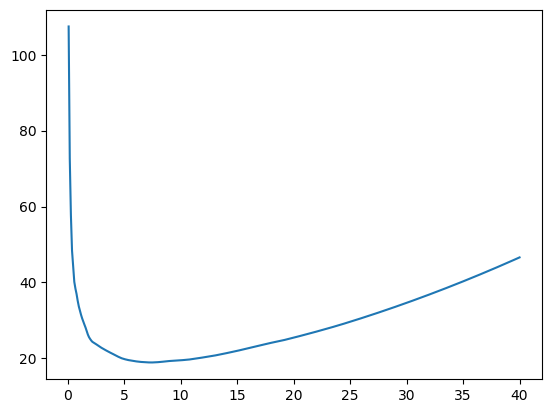

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146914a20>

In [22]:
plot(ρ_l1, errors_l1)    

In [23]:
ρ_optimal_l1 = ρ_l1[argmin(errors_l1)]

7.4

In [24]:
ρ_l2 = vcat([i/10 for i=1:200])
errors_l2 = zeros(length(ρ_l2))

for i in 1:length(errors_l2)
    print("__________________________", "iteration : ", i, "__________________________")
    errors_l2[i] = compute_error_l2(ρ_l2[i], X_validation, y_validation)
end

__________________________iteration : 1__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.12905210e+02 -1.35535147e+01  4.61e-08 2.29e+02  0.00e+00     0s
   2  -4.87570793e+02 -

__________________________iteration : 7__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.75077482e+02 -2.37748481e+01  4.48e-08 2.19e+02  0.00e+00     0s
   2  -5.22097990e+02 -

__________________________iteration : 13__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.66415823e+02 -2.23344922e+01  3.46e-08 2.20e+02  0.00e+00     0s
   2  -5.29929150e+02 

__________________________iteration : 19__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.36302513e+02 -1.73341650e+01  3.61e-08 2.25e+02  0.00e+00     0s
   2  -4.76168672e+02 

__________________________iteration : 25__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.57900293e+02 -2.10907713e+01  2.94e-08 2.21e+02  0.00e+00     0s
   2  -5.42321056e+02 

__________________________iteration : 31__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.74577825e+02 -2.43428728e+01  4.65e-08 2.18e+02  0.00e+00     0s
   2  -5.41592306e+02 

__________________________iteration : 37__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -3.07642917e+02 -3.14994797e+01  3.93e-08 2.12e+02  0.00e+00     0s
   2  -5.62458045e+02 

__________________________iteration : 43__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.37194011e+02 -1.79147879e+01  3.64e-08 2.24e+02  0.00e+00     0s
   2  -4.42773557e+02 

__________________________iteration : 49__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -3.05020244e+02 -3.12905963e+01  4.63e-08 2.12e+02  0.00e+00     0s
   2  -5.24263854e+02 

__________________________iteration : 55__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.73352541e+02 -2.46964196e+01  3.95e-08 2.17e+02  0.00e+00     0s
   2  -5.97722947e+02 

__________________________iteration : 61__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -3.06227727e+02 -3.19467779e+01  3.81e-08 2.11e+02  0.00e+00     0s
   2  -5.61029353e+02 

__________________________iteration : 67__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.58861583e+02 -2.21663507e+01  3.38e-08 2.19e+02  0.00e+00     0s
   2  -4.92664859e+02 

__________________________iteration : 73__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.73462727e+02 -2.51423510e+01  4.24e-08 2.16e+02  0.00e+00     0s
   2  -5.73431834e+02 

__________________________iteration : 79__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.69288385e+02 -2.44391367e+01  3.25e-08 2.17e+02  0.00e+00     0s
   2  -5.33425116e+02 

__________________________iteration : 85__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.95836667e+02 -3.02579767e+01  3.19e-08 2.12e+02  0.00e+00     0s
   2  -5.18900057e+02 

__________________________iteration : 91__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.37389156e+02 -1.87516165e+01  4.06e-08 2.22e+02  0.00e+00     0s
   2  -4.48857347e+02 

__________________________iteration : 97__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.98300217e+02 -3.11593717e+01  3.65e-08 2.11e+02  0.00e+00     0s
   2  -5.09011144e+02 

__________________________iteration : 103__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.87230489e+02 -2.87942250e+01  3.22e-08 2.13e+02  0.00e+00     0s
   2  -5.47260359e+02

__________________________iteration : 109__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.94998034e+02 -3.07183967e+01  3.36e-08 2.11e+02  0.00e+00     0s
   2  -5.82433971e+02

__________________________iteration : 115__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.82842622e+02 -2.81163961e+01  4.70e-08 2.13e+02  0.00e+00     0s
   2  -5.29071911e+02

__________________________iteration : 121__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.79787110e+02 -2.75867600e+01  2.91e-08 2.14e+02  0.00e+00     0s
   2  -5.31315071e+02

__________________________iteration : 127__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.77098762e+02 -2.71384420e+01  3.74e-08 2.14e+02  0.00e+00     0s
   2  -5.36934706e+02

__________________________iteration : 133__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.58813740e+02 -2.34566160e+01  5.51e-08 2.17e+02  0.00e+00     0s
   2  -5.01597252e+02

__________________________iteration : 139__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -3.06778493e+02 -3.44095262e+01  4.34e-08 2.08e+02  0.00e+00     0s
   2  -5.67935204e+02

__________________________iteration : 145__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.41726600e+02 -2.03900979e+01  4.32e-08 2.20e+02  0.00e+00     0s
   2  -5.19583666e+02

__________________________iteration : 151__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.53948104e+02 -2.28242988e+01  3.71e-08 2.17e+02  0.00e+00     0s
   2  -4.90510652e+02

__________________________iteration : 157__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.55164640e+02 -2.31742338e+01  4.80e-08 2.17e+02  0.00e+00     0s
   2  -4.76615442e+02

__________________________iteration : 163__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.82026553e+02 -2.90611966e+01  3.63e-08 2.12e+02  0.00e+00     0s
   2  -5.98471869e+02

__________________________iteration : 169__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.43244790e+02 -2.10585182e+01  3.04e-08 2.19e+02  0.00e+00     0s
   2  -5.06954565e+02

__________________________iteration : 175__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.37622282e+02 -2.00994920e+01  3.06e-08 2.20e+02  0.00e+00     0s
   2  -5.32404840e+02

__________________________iteration : 181__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.94667034e+02 -3.25172553e+01  3.33e-08 2.09e+02  0.00e+00     0s
   2  -5.00870808e+02

__________________________iteration : 187__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.99705632e+02 -3.39420031e+01  3.52e-08 2.07e+02  0.00e+00     0s
   2  -5.71330106e+02

__________________________iteration : 193__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.80829470e+02 -2.94668435e+01  3.23e-08 2.11e+02  0.00e+00     0s
   2  -5.12294340e+02

__________________________iteration : 199__________________________Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.20259619e+02 -1.73413444e+01  3.32e-08 2.22e+02  0.00e+00     0s
   2  -4.83758482e+02

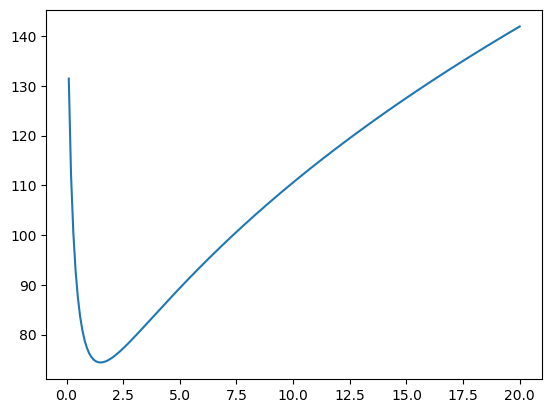

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141ac39b0>

In [25]:
plot(ρ_l2, errors_l2)  

In [26]:
ρ_optimal_l2 = ρ_l2[argmin(errors_l2)]

1.5

Compute ∥y − Xβ∥2 on the testing set using the β’s from l0-regularized, l1-regularized linear regression, l2- regularized linear regression, and standard linear regression (ρ = 0)

In [27]:
l0_error = compute_error_l0(ρ_optimal_l0, X_test, y_test)

Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve time: 0.00s
Presolved: 200 rows, 200 columns, 400 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.471986e+02, 1042 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -947.19856    0   97    0.00000 -947.19856      -     -    0s
H    0     0                    -871.5529557 -947.19856  8.68%     -    0s
H  

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/gabriellerappaport/.julia/packages/JuMP/I7whV/src/solvers.jl:212


11.850568312130758

In [28]:
l1_error = compute_error_l1(ρ_optimal_l1, X_test, y_test)

Academic license - for non-commercial use only
Optimize a model with 200 rows, 200 columns and 400 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 200 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 9.900e+03
 Factor NZ  : 1.219e+04
 Factor Ops : 1.092e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.47260000e+06  0.00000000e+00  0.00e+00 2.53e+02  1.00e+06     0s
   1   1.45007288e+06 -9.46754461e+02  1.90e-07 2.54e-04  7.26e+03     0s
   2   1.60356333e+03 -9.46597343e+02  1

16.372850575034654

In [29]:
l2_error = compute_error_l2(ρ_optimal_l2, X_test, y_test)

Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -3.21324770e+02 -3.38616925e+01  4.14e-08 2.11e+02  0.00e+00     0s
   2  -5.49986761e+02 -1.20755618e+02  3.78e-08 1.67e+02  0.00e+00     0s
   3  -7.85709

92.41964034422318

In [37]:
SLR_error = compute_error_l2(0, X_test, y_test)

Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.20272664e+02 -1.45460440e+01  2.93e-08 2.28e+02  0.00e+00     0s
   2  -4.71488759e+02 -8.03286083e+01  3.73e-08 1.85e+02  0.00e+00     0s
   3  -7.65776

80481.330100569

In [31]:
function baseline_error(y, data)
    avg = mean(data)
    error = sum((y .- avg).^2)
    return(error)
end

baseline_error (generic function with 1 method)

In [38]:
b_error = baseline_error(y_test, convert(Matrix,sparseY2))

706.6955205363149

In [40]:
println(" l0 error: ", l0_error, " for ρ: ", ρ_optimal_l0)
println(" l1 error: ", l1_error, " for ρ: ", ρ_optimal_l1)
println(" l2 error: ", l2_error, " for ρ: ", ρ_optimal_l2)
println(" SLR error: ", SLR_error)
println(" baseline error: ", b_error)

 l0 error: 11.850568312130758 for ρ: 1.0
 l1 error: 16.372850575034654 for ρ: 7.4
 l2 error: 92.41964034422318 for ρ: 1.5
 SLR error: 80481.330100569
 baseline error: 706.6955205363149


In [34]:
objective, β_l0 = regularized_regression_l2(y_train, X_train, ρ_optimal_l0)
objective, β_l1 = regularized_regression_l2(y_train, X_train, ρ_optimal_l1)
objective, β_l2 = regularized_regression_l2(y_train, X_train, ρ_optimal_l2)

Academic license - for non-commercial use only
Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-01, 3e+02]
  QObjective range [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 100 columns, 0 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 2.60e+02  0.00e+00     0s
   1  -2.87829316e+02 -2.63625224e+01  4.37e-08 2.17e+02  0.00e+00     0s
   2  -5.25802247e+02 -1.06906776e+02  7.20e-08 1.72e+02  0.00e+00     0s
   3  -8.15271

(16.260375461826925, [-0.8381864066727036, -0.8017399684889693, 0.9334950283947882, 0.7919681518430199, 0.993651996277456, -1.113839804110867, -0.875193737374284, 0.861489667027097, -0.9912304201728337, 0.8843952714299707  …  0.1441816471765873, -0.2003382119638942, 0.01595479115787006, 0.008426047137969836, -0.005877393402344458, 0.04319945956803077, 0.14165567027340922, 0.06295225265686392, -0.05133172543090636, 0.044721378475104705])

In [36]:
print(max(β_l0))

MethodError: MethodError: no method matching max(::Array{Float64,1})
Closest candidates are:
  max(::Any, !Matched::Missing) at missing.jl:104
  max(::Any, !Matched::Any) at operators.jl:408
  max(::Any, !Matched::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  ...